In [433]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import csv
from matplotlib.colors import LinearSegmentedColormap
from numpy.typing import ArrayLike
from typing import List, Tuple

In [434]:
def generate_bin_list(data_dir: str) -> list[int]:
    """
    loads changepoint csv into 0 and 1 list 
    """
    # load data
    data = pd.read_csv(data_dir)
    data = data.drop(data.filter(regex="Unname") ,axis=1)  # accidentally added index col which I should drop
    
    # Initialize variables
    holding_list = []
    current_index = 0
    last_holding_index = 0
    last_not_holding_index = 0

    # Iterate through each row in the data
    for index, row in data.iterrows():
        holding_transitions, not_holding_transitions = row

        # Add "not_holding" (0) entries until the current holding transition point
        for _ in range(last_not_holding_index, holding_transitions):
            holding_list.append(0)
            last_not_holding_index += 1

        # Add "holding" (1) entries from the current holding transition point to the not holding transition point
        for _ in range(holding_transitions, not_holding_transitions):
            holding_list.append(1)
            last_holding_index += 1

        # Update last indices
        last_not_holding_index = not_holding_transitions

    return holding_list

def plot_barcode(class_num, gt=None, pred=None, show=True, save_file=None):

    if class_num <= 10:
        color_map = plt.cm.tab10
    elif class_num > 20:
        color_map = plt.cm.gist_ncar
    else:
        color_map = plt.cm.tab20

    # red = np.array([1, 0, 0, 1])
    red = [0.47, 0.11, 0.2, 1]  # RGB values for #c81c34
    red = np.append(np.array([200, 28, 52])/255, np.array([1]))
    # green = np.array([0, 1, 0, 1])
    green = [0.43, 0.76, 0.46, 1]  # RGB values for #6fc276
    green = np.append(np.array([38,140,47])/255, np.array([1]))
    colors = [red, green]
    color_map = LinearSegmentedColormap.from_list("Custom", colors, N=2)

    axprops = dict(xticks=[], yticks=[], frameon=False)
    barprops = dict(aspect='auto', cmap=color_map, 
                interpolation='nearest', vmin=0, vmax=1)

    # axprops = dict(xticks=[], yticks=[], frameon=False)
    # barprops = dict(aspect='auto', cmap=color_map, 
    #             interpolation='nearest', vmin=0, vmax=class_num-1)

    fig = plt.figure(figsize=(18, 4))

    # a horizontal barcode
    if gt is not None:
        ax1 = fig.add_axes([0, 0.45, 1, 0.2], **axprops)
        ax1.set_title('Ground Truth')
        ax1.imshow(gt.reshape((1, -1)), **barprops)

    if pred is not None:
        ax2 = fig.add_axes([0, 0.15, 1, 0.2], **axprops)
        ax2.set_title('Predicted')
        ax2.imshow(pred.reshape((1, -1)), **barprops)

    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    if show:
        plt.show()
    plt.close()
    
    
def plot_iterative_barcodes(data_list, titles=None, show=True, save_file=None):
    if not data_list:  # If the list is empty
        print("No data provided.")
        return

    # red = np.array([1, 0, 0, 1])
    # green = np.array([0, 1, 0, 1])
    red = np.append(np.array([200, 28, 52])/255, np.array([1]))
    green = np.append(np.array([38,140,47])/255, np.array([1]))
    colors = [red, green]
    color_map = LinearSegmentedColormap.from_list("Custom", colors, N=2)

    axprops = dict(xticks=[], yticks=[], frameon=False)
    barprops = dict(aspect='auto', cmap=color_map, 
                interpolation='nearest', vmin=0, vmax=1)
    
    # Adjust figure size dynamically based on number of barcodes
    fig_height_per_barcode = 0.4  # Adjust this based on desired spacing and size
    fig_height = len(data_list) * fig_height_per_barcode
    fig = plt.figure(figsize=(18, fig_height))

    for idx, data in enumerate(data_list):
        ax_position = [0, 1 - (idx + 1) * fig_height_per_barcode, 1, fig_height_per_barcode * 0.8]  # Adjust this based on desired layout
        ax = fig.add_axes(ax_position, **axprops)
        if titles and idx < len(titles):
            ax.set_ylabel(titles[idx])
        ax.imshow(data.reshape((1, -1)), **barprops)

    if save_file is not None:
        fig.savefig(save_file, dpi=400)
    if show:
        plt.show()
    plt.close()
    
def condense_dataframe(df: pd.DataFrame, priority: dict = None) -> pd.DataFrame:
    """
    deals with duplicate images which have multiple contact states
    
    Condenses a pandas DataFrame by ensuring each 'image' entry is unique and retains
    the most relevant 'contact_label_pred' based on a set priority.

    The function operates under the rule that if multiple entries exist for the same 'image',
    it prioritizes keeping the entry with 'contact_label_pred' as "Portable Object Contact" over
    "Stationary Object Contact", and "Stationary Object Contact" over "No Contact". This is
    done by sorting the DataFrame according to the 'image' and a custom priority assigned to
    'contact_label_pred', then removing duplicate 'image' entries while keeping the entry with the
    highest-priority 'contact_label_pred'.
    """
    # df = df.loc[df['probability'] > 95].copy()
    # plt.hist(df["probability"], bins=50)
    # plt.show()
    if priority is None:
        priority = {
            "Portable Object": 1,
            "Portable Object Contact": 1,
            "Stationary Object Contact": 2,
            "No Contact": 3
        }

    # Sort the DataFrame based on 'image' and the custom priority of 'contact_label_pred'

    df['priority'] = df['contact_label_pred'].map(priority)

    df = df.sort_values(by=['frame_id', 'priority'])

    # Drop the 'priority' column as it's no longer needed after sorting
    df.drop('priority', axis=1, inplace=True)

    # Remove duplicates, keeping the first occurrence
    df = df.drop_duplicates(subset='frame_id', keep='first')

    return df.iloc[df['frame_id'].map(lambda x: int(x.split('_')[0])).argsort()].reset_index(drop=True)

def load_arrays(true_dir: str, pred_dir: str, single_priority = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    return: (true_labels, pred_labels)
    """
    true_labels = np.asarray(generate_bin_list(true_dir))
    
    pred_df = pd.read_csv(pred_dir)
    pred_df["bbox"] = pred_df["bbox"].apply(eval) # converts bbox string into list
    
    if single_priority:
        priority = {
                "Portable Object": 3,
                "Portable Object Contact": 3,
                "Stationary Object Contact": 1,
                "No Contact": 2
            }
    else:
        priority = None
    
    pred_cond_df = condense_dataframe(pred_df, priority=priority)

    # pad true with 0's at the end (bc only goes up to last changepoint)
    true_labels = np.pad(true_labels, (0, (len(pred_cond_df) - len(true_labels))), mode='constant')
    
    mapping = {"Portable Object": 1,
               "Portable Object Contact": 1,
               "No Contact": 0 ,
               "Stationary Object Contact": 0,
               "Self Contact": 0}
    pred_labels = pred_cond_df["contact_label_pred"].map(mapping).to_numpy().astype(np.int8)
    return true_labels, pred_labels

def continuous_sequence_indices(arr: ArrayLike, n: int, target: int = 1, pad_percent: int = 5) -> List[tuple]:
    """
    Finds indices of all uninterrupted sequences of 1's of at least length n.

    Parameters:
        arr: numpy array of 1's and 0's.
        n: minimum length of the sequence to find.
        target: the target number we search for
        pad_percent: removes pad_percent% of sequences from BOTH sides: a result of (100, 200) becomes (105, 195) with pad_percent=5

    Returns:
    - A list of tuples, where each tuple contains the start and end indices of each sequence found.
    
    Example:
        arr = np.array([0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])
        continuous_sequence_indices(arr, 5)
        returns: [(5, 12)]
    """
    # Convert the array to a string to easily find sequences
    arr_str = ''.join(arr.astype(str))
    
    # Find sequences of '1' of at least length n
    sequences = []
    start = 0
    while start < len(arr_str):
        # Find the start of the next sequence of 1's
        start = arr_str.find(str(target) * n, start)
        if start == -1:
            # No more sequences found
            break
        # Find the end of this sequence
        end = start + n
        while end < len(arr_str) and arr_str[end] == str(target):
            end += 1
        # Add the sequence to the list
        seq_len = end - 1 - start
        to_trim = int(pad_percent / 100 * seq_len)

        sequences.append((start + to_trim, end - 1 - to_trim))
        # Move past this sequence
        start = end
    return sequences

def extract_values_from_indices(source_array, index_ranges):
    """Extracts segments from source_array based on start/end indices in index_ranges."""
    extracted_values = []
    for start, end in index_ranges:
        # Extract values between start and end indices (inclusive)
        extracted_values.append(source_array[start:end + 1])
    return extracted_values

In [445]:
from sklearn.metrics import confusion_matrix

class Labeler:
    def __init__(self, all_preds_dir: str, fps: int = 60, gt_dir = None) -> None:
        self.all_preds_dir = all_preds_dir
        self.fps = fps
        self.gt_dir = gt_dir
        # Need multiple hands with portable object detection for frame to be labeled as such (maximize sensitivity for contact)
        self.priority_multi_mapping = {"Portable Object": 4,
                                       "Portable Object Contact": 4,
                                       "Stationary Object Contact": 1,
                                       "No Contact": 2,
                                       "Self Contact": 3}
        # Need 1 hand with portable object detection for frame to be labeled as such (maximize sensitivity for non-contact)
        self.priority_single_mapping = {"Portable Object": 1,
                                        "Portable Object Contact": 1,
                                        "Stationary Object Contact": 2,
                                        "No Contact": 3,
                                        "Self Contact": 4}
        # results to binary: portable object contact is a "yes", everything else is a "no"
        self.binary_mapping = {"Portable Object": 1,  
                               "Portable Object Contact": 1,
                               "No Contact": 0 ,
                               "Stationary Object Contact": 0,
                               "Self Contact": 0}
        
    def __call__(self, *args, **kwargs):
        return self._get_labels()
        
    def _get_labels(self) -> Tuple[np.ndarray, np.ndarray]:        
        pred_df = pd.read_csv(self.all_preds_dir)
        pred_df["bbox"] = pred_df["bbox"].apply(eval) # converts bbox string into list
        
        priority_single_pred = condense_dataframe(pred_df, priority=self.priority_single_mapping)
        priority_multi_pred = condense_dataframe(pred_df, priority=self.priority_multi_mapping)
    
        # arrays of 0 and 1 for each priority type
        priority_single_binary = priority_single_pred["contact_label_pred"].map(self.binary_mapping).to_numpy().astype(np.int8)  # confident in 0's
        priority_multi_binary = priority_multi_pred["contact_label_pred"].map(self.binary_mapping).to_numpy().astype(np.int8)  # confident in 1's
        
        non_contact_indices = np.where(priority_single_binary == 0)[0]  # ready to return
        
        # we get lots of false positives (predicts contact when there isn't, so we can be selective in which labels we use with single priority, thus improving sensitivity)
        # for single detection priority, we want to only include regions which are at least 1 second long, pad them by 10% on each side
        refined_ones_intervals = continuous_sequence_indices(priority_multi_binary, n=self.fps, target=1, pad_percent=10)
        
        contact_indices = []
        for interval_start, interval_end in refined_ones_intervals:
            contact_indices.extend(list(range(interval_start, interval_end + 1)))
        contact_indices = np.asarray(contact_indices)  # ready to return
        
        return non_contact_indices, contact_indices
        
    def tp_fp(self) -> Tuple[Tuple[int, int], Tuple[int, int]]:
        """
        find true positives and false positives
        :return: ((non-contact tp, non-contact fp), (contact tp, contact fp))
        """
        # note: we care about precision, not recall because recall tells us how many of the actual positive instances were captured by the model. It is a measure of completeness. We aren't trying to get all the labels
        if self.gt_dir is None:
            raise Exception("No GT dir is provided in object initialization, can't evaluate predictions")
        
        true_labels_full = np.asarray(generate_bin_list(self.gt_dir))
    
        # only doing this to get the correct length, the way it's condensed into the correct length and doesn't matter here
        pred_df = pd.read_csv(self.all_preds_dir)        
        pred_cond_df = condense_dataframe(pred_df)
    
        # pad true with 0's at the end (bc only goes up to last changepoint)
        true_labels_full = np.pad(true_labels_full, (0, (len(pred_cond_df) - len(true_labels_full))), mode='constant')
    
        # now that we have the true labels, let's get the predictions:    
        non_contact_indices, contact_indices = self._get_labels()
        
        # non contact true labels
        true_labels_non_contact = true_labels_full[non_contact_indices]
        
        if np.all(true_labels_non_contact == 1):  # handle edge case for all predictions are right
            tp_non_contact = len(true_labels_non_contact)
            fp_non_contact = 0
        else:
            # we do 1 - because it assumes 1 is the positive class, but we treat 0 as positive class for non-contact evaluation
            cm_non_contact = confusion_matrix(1 - true_labels_non_contact, [1] * len(true_labels_non_contact))
        
            fp_non_contact = cm_non_contact[0][1]
            tp_non_contact = cm_non_contact[1][1]
        tp_fp_non_contact = (tp_non_contact, fp_non_contact)  # ready to return
        
        # contact true labels
        true_labels_contact = true_labels_full[contact_indices]
        
        if np.all(true_labels_contact == 1):  # handle edge case for all predictions are right
            tp_contact = len(true_labels_contact)
            fp_contact = 0
        else:
            # we don't 1 - because it assumes 1 is the positive class
            cm_contact = confusion_matrix(true_labels_contact, [1] * len(true_labels_contact))
            print(cm_contact)
            fp_contact = cm_contact[0][1]
            tp_contact = cm_contact[1][1]
        tp_fp_contact = (tp_contact, fp_contact)  # ready to return
        
        return tp_fp_non_contact, tp_fp_contact
        
    def get_precision(self) -> Tuple[float, float]:
        """returns: (non contact precision, contact precision)"""
        (tp_non_contact, fp_non_contact), (tp_contact, fp_contact) = self.tp_fp()
        return tp_non_contact / (tp_non_contact + fp_non_contact), tp_contact / (tp_contact + fp_contact)
        
    
sr2_gt_dir = "/Users/NoahRipstein/Downloads/shafee group stuff/sr labels/sr2/changepoints.csv"
sr2_pred_dir = "/Users/NoahRipstein/Downloads/pred csvs thesis/sr2/pred_every_obj.csv"

my_labeler = Labeler(sr2_pred_dir, fps=60, gt_dir=sr2_gt_dir)
non_contact_indices, contact_indices = my_labeler()
print(len(non_contact_indices), len(contact_indices))
print(my_labeler.get_precision())

663 1621
(0.9532428355957768, 1.0)


# Experimenting to get it to work (nothing below here is needed now that I have the class)

In [435]:
sv2_true = generate_bin_list("/Users/NoahRipstein/Downloads/shafee group stuff/sr labels/sr2/changepoints.csv")

sv2_pred = pd.read_csv("/Users/NoahRipstein/Downloads/pred csvs thesis/sr2/pred_every_obj.csv")
sv2_pred["bbox"] = sv2_pred["bbox"].apply(eval) # converts bbox string into list

display(sv2_pred.iloc[sv2_pred['frame_id'].map(lambda x: int(x.split('_')[0])).argsort()].reset_index(drop=True).head())
# display(sv2_pred.head())
sv2_pred_cond = condense_dataframe(sv2_pred)
# display(sv2_pred_cond.head())


sv2_pred = np.array(sv2_pred)
sv2_true = np.array(sv2_true)

sv2_true = np.pad(sv2_true, (0, (len(sv2_pred_cond) - len(sv2_true))), mode='constant')

# print(len(sv2_pred_cond), len(sv2_true))

,frame_id,contact_label_pred,probability,bbox,type,which,other_detail
0,0_sh2.jpg,Portable Object,99,"[338, 177, 444, 299]",hand,Right,NaN
1,0_sh2.jpg,Stationary Object Contact,99,"[168, 173, 307, 314]",hand,Left,NaN
2,1_sh2.jpg,Portable Object,99,"[338, 177, 444, 301]",hand,Right,NaN
3,1_sh2.jpg,Stationary Object Contact,99,"[169, 170, 308, 314]",hand,Left,NaN
4,2_sh2.jpg,Portable Object,99,"[338, 177, 444, 300]",hand,Right,NaN


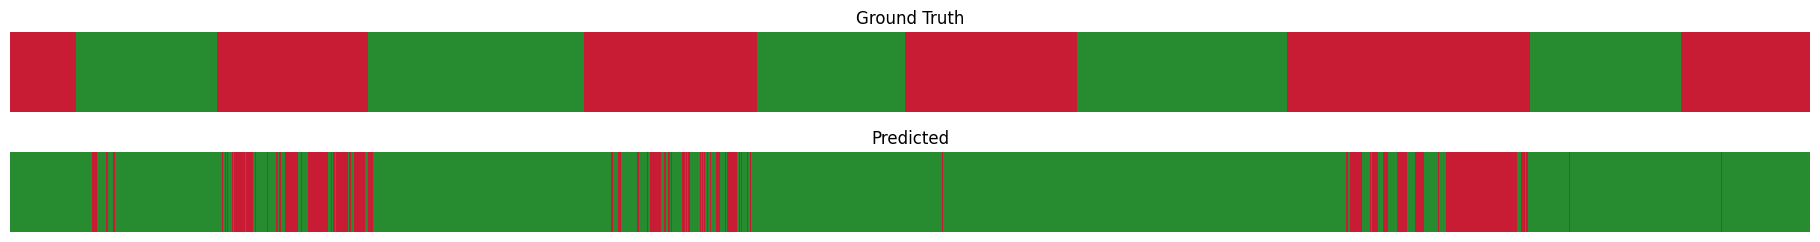

In [436]:
mapping = {"Portable Object": 1,
               "Portable Object Contact": 1,
               "No Contact": 0 ,
               "Stationary Object Contact": 0,
               "Self Contact": 0}
plot_barcode(class_num=50,
             gt=sv2_true,
             pred=sv2_pred_cond["contact_label_pred"].map(mapping).to_numpy().astype(np.int8),
             save_file=None)

# predictions.map({"Portable Object": 1, "No Contact": 0 , "Stationary Object Contact": 0}).to_numpy().astype(np.int8),

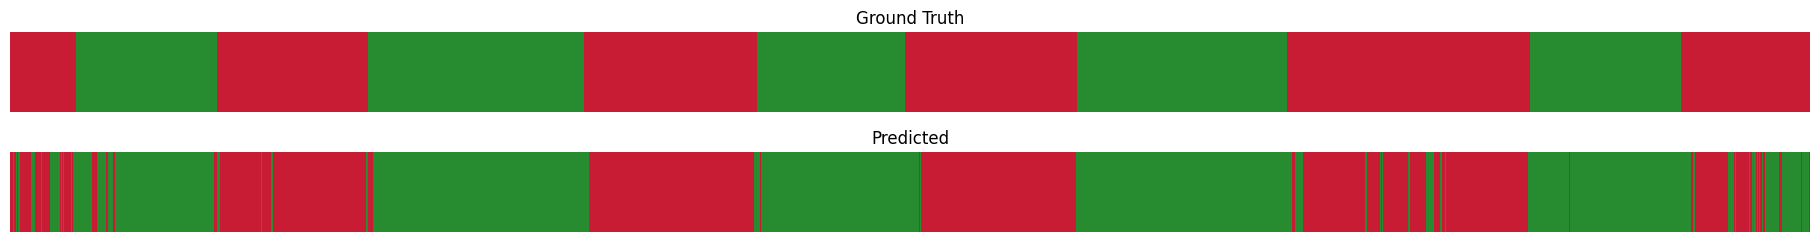

In [437]:
true, pred = load_arrays("/Users/NoahRipstein/Downloads/shafee group stuff/sr labels/sr2/changepoints.csv",
                         "/Users/NoahRipstein/Downloads/pred csvs thesis/sr2/pred_every_obj.csv")

plot_barcode(class_num=50,
             gt=true,
             pred=pred,
             save_file=None)

# Metrics:

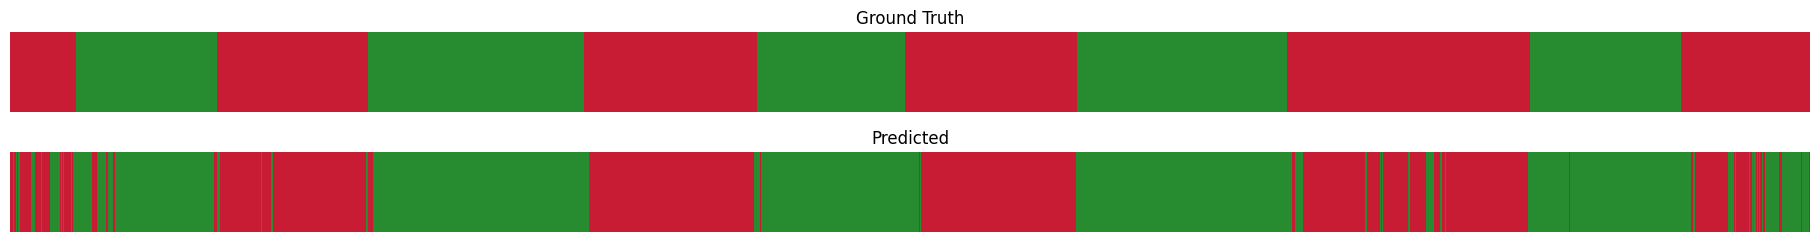

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
1.0


In [438]:
from sklearn.metrics import confusion_matrix, precision_score
def accuracy_false(true_arr, pred_arr):
    cm = confusion_matrix(1- true_arr, 1 -pred_arr)
    
    # tn = cm[0][0]
    # fp = cm[0][1]
    # fn = cm[1][0]
    # tp = cm[1][1]
    # 
    # print(tp, tn, fp, fn)
    
    # print(accuracy_score(true_arr, pred_arr))
    # precision, recall, fscore, support = precision_recall_fscore_support(true_arr, pred_arr)
    precision = precision_score(true_arr, pred_arr)
    print(precision)
    # print(recall)
    # print(fscore)
    
sr2 = load_arrays("/Users/NoahRipstein/Downloads/shafee group stuff/sr labels/sr2/changepoints.csv",
                         "/Users/NoahRipstein/Downloads/pred csvs thesis/sr2/pred_every_obj.csv",
                  single_priority=True)

plot_barcode(class_num=50,
             gt=sr2[0],
             pred=sr2[1],
             save_file=None)

# for getting positives
positive_indices = continuous_sequence_indices(sr2[1], n=60, target=1, pad_percent=10)
# positive_indices
print(np.concatenate(extract_values_from_indices(sr2[1], positive_indices)))
print(np.concatenate(extract_values_from_indices(sr2[0], positive_indices)))
accuracy_false(np.concatenate(extract_values_from_indices(sr2[0], positive_indices)), np.concatenate(extract_values_from_indices(sr2[1], positive_indices)))

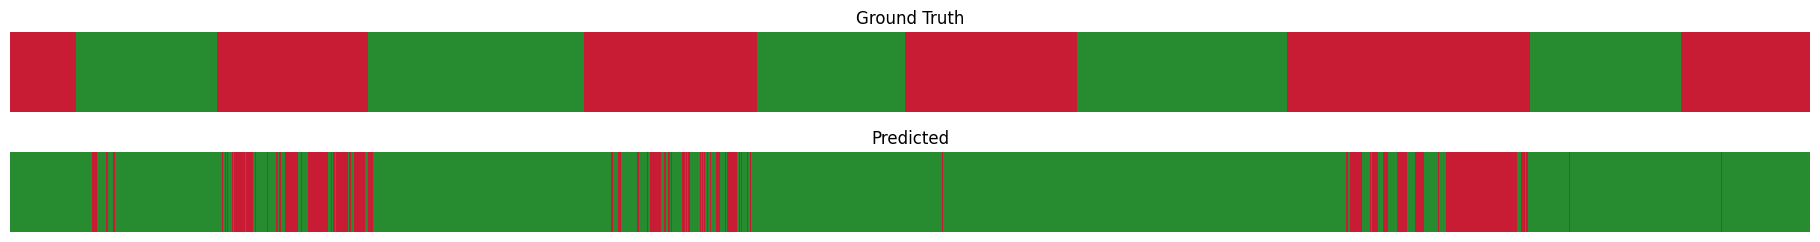

0.9532428355957768


In [439]:
from sklearn.metrics import confusion_matrix, precision_score
def accuracy_false(true_arr, pred_arr):
    cm = confusion_matrix(1- true_arr, 1 -pred_arr)
    
    # tn = cm[0][0]
    # fp = cm[0][1]
    # fn = cm[1][0]
    # tp = cm[1][1]
    # 
    # print(tp, tn, fp, fn)
    
    # print(accuracy_score(true_arr, pred_arr))
    # precision, recall, fscore, support = precision_recall_fscore_support(true_arr, pred_arr)
    precision = precision_score(1 - true_arr, 1 - pred_arr)
    print(precision)
    # print(recall)
    # print(fscore)
    
sr2 = load_arrays("/Users/NoahRipstein/Downloads/shafee group stuff/sr labels/sr2/changepoints.csv",
                         "/Users/NoahRipstein/Downloads/pred csvs thesis/sr2/pred_every_obj.csv",
                  single_priority=False)

plot_barcode(class_num=50,
             gt=sr2[0],
             pred=sr2[1],
             save_file=None)


accuracy_false(sr2[0], sr2[1])

# Automating precision checks:

In [ ]:
arr = np.array([1, 0, 3, 0, 0, 5, 0])

# Find indices where value 0 occurs
indices = np.where(arr == 0)

print(indices)